In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import io, base64, os, json, re 
import pandas as pd
import numpy as np
import datetime
from random import randint
from sklearn.metrics import confusion_matrix

In [2]:
gspc_df = pd.read_csv('SPX.csv')
gspc_df['Date'] = pd.to_datetime(gspc_df['Date'])

cut_off_date = '2010-01-01' 
gspc_df = gspc_df[gspc_df['Date'] >= cut_off_date]


gspc_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
20593,2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3991400000
20594,2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2491020000
20595,2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4972660000
20596,2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5270680000
20597,2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4389590000


<AxesSubplot:>

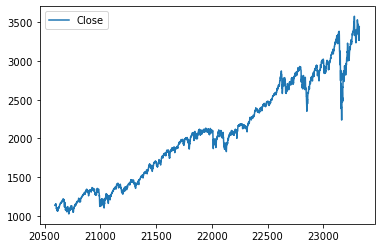

In [3]:
gspc_df.plot.line(y="Close", use_index=True)

In [4]:
gspc_df["Tomorrow"] = gspc_df["Close"].shift(-1)
gspc_df["Target"] = (gspc_df["Tomorrow"] > gspc_df["Close"]).astype(int)
gspc_df = gspc_df.loc["2010-01-01":].copy()

from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = gspc_df.iloc[:-100]
test = gspc_df.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [5]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.6792452830188679

<AxesSubplot:>

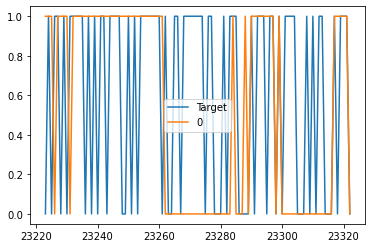

In [6]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [7]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [8]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [9]:
predictions = backtest(gspc_df, model, predictors)

predictions["Predictions"].value_counts()

0    190
1     40
Name: Predictions, dtype: int64

In [10]:
precision_score(predictions["Target"], predictions["Predictions"])

0.575

In [11]:
predictions["Target"].value_counts() / predictions.shape[0]

1    0.586957
0    0.413043
Name: Target, dtype: float64

In [12]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = gspc_df.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    gspc_df[ratio_column] = gspc_df["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    gspc_df[trend_column] = gspc_df.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors+= [ratio_column, trend_column]

In [13]:
gspc_df = gspc_df.dropna(subset=gspc_df.columns[gspc_df.columns != "Tomorrow"])
gspc_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
21593,2013-12-23,1822.920044,1829.750000,1822.920044,1827.989990,1827.989990,2851540000,1833.319946,1,1.002652,2.0,1.010212,3.0,1.037942,33.0,1.116595,145.0,1.348619,557.0
21594,2013-12-24,1828.020020,1833.319946,1828.020020,1833.319946,1833.319946,1307630000,1842.020020,1,1.001456,2.0,1.007332,4.0,1.039475,34.0,1.118715,146.0,1.351857,557.0
21595,2013-12-26,1834.959961,1842.839966,1834.959961,1842.020020,1842.020020,1982270000,1841.400024,0,1.002367,2.0,1.008635,4.0,1.042959,34.0,1.122820,147.0,1.357566,557.0
21596,2013-12-27,1842.969971,1844.890015,1839.810059,1841.400024,1841.400024,2052920000,1841.069946,0,0.999832,1.0,1.004796,4.0,1.041158,34.0,1.121306,146.0,1.356410,556.0
21597,2013-12-30,1841.469971,1842.469971,1838.770020,1841.069946,1841.069946,2293860000,1848.359985,1,0.999910,0.0,1.002128,3.0,1.039381,34.0,1.120072,145.0,1.355472,555.0


In [14]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [19]:
predictions["Predictions"].value_counts()

0    190
1     40
Name: Predictions, dtype: int64

In [20]:
precision_score(predictions["Target"], predictions["Predictions"])

0.575

In [21]:
predictions["Target"].value_counts() / predictions.shape[0]

1    0.586957
0    0.413043
Name: Target, dtype: float64

<AxesSubplot:>

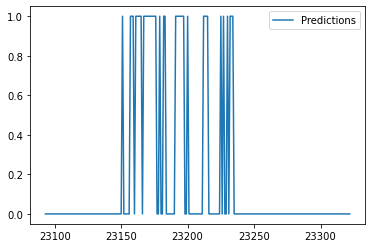

In [23]:
predictions.plot.line(y="Predictions", use_index=True)